<a href="https://colab.research.google.com/github/pathikritsyam/ECTA/blob/main/ANN/ANN_%26_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# 04.02 - Exploratory Data Analysis & ANN & Genetic Algorithm - Full Notebook

## Imports & setup

In [ ]:
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import palettable
import seaborn as sns
%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'

plt.style.use('grayscale')
# Custom Overrides to grayscale
params = {'legend.fontsize': 'x-large',
          'lines.linewidth': 0.75,
      'figure.figsize': (15, 7),
          'grid.color': 'white',
          'axes.axisbelow': False,
          'axes.grid': True,
          'axes.grid.axis': 'y',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'xx-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
figsize=(15,7)

## Load Data

In [ ]:
dtypes = {'temp': np.float64, 'dew_point_temp':np.float64, 'rel_hum':np.float64,
          'wind_speed': np.float64, 'visibility': np.float64, 'press': np.float64,
          'hmdx': np.float64, 'wind_chill': np.float64, 'weather': np.object,
         'hour_of_day': np.float64, 'year': np.float64, 'month': np.float64,
         'day_of_week': np.float64, 'day_of_year': np.float64, 'week_of_year': np.float64,
          'quarter': np.float64, 'stat_hol': 'category', 'day_light_hours': 'category',
          'hourly_demand': np.float64, 'daily_peak': np.float64}


df_orig = pd.read_csv("/content/clean-cut.csv", parse_dates=True,
                 dtype=dtypes, index_col=0, infer_datetime_format=True)

daymapper = {0.0: 'Mon', 1.0: 'Tue', 2.0: 'Wed', 3.0: 'Thu', 4.0: 'Fri', 5.0: 'Sat', 6.0: 'Sun'}
weekdaymapper = {0.0: 'Weekday', 1.0: 'Weekday', 2.0: 'Weekday', 3.0: 'Weekday', 4.0: 'Weekday',
                 5.0: 'Weekend', 6.0: 'Weekend'}
df_orig['dayofweek'] = df_orig['day_of_week'].map(daymapper)
df_orig['daytype'] = df_orig['day_of_week'].map(weekdaymapper)


<ipython-input-4-057221e1f04b>:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'hmdx': np.float64, 'wind_chill': np.float64, 'weather': np.object,


In [ ]:
df_orig.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather,hour_of_day,...,day_of_week,day_of_year,week_of_year,quarter,stat_hol,day_light_hours,hourly_demand,daily_peak,dayofweek,daytype
1994-01-01 00:00:00,-1.2,-3.8,83.0,15.0,19.3,99.91,NaN,-6.0,Cloudy,0.0,...,5.0,1.0,52.0,1.0,True,False,14422.0,16892.0,Sat,Weekend
1994-01-01 01:00:00,-0.9,-3.0,86.0,20.0,16.1,99.91,NaN,-6.0,Cloudy,1.0,...,5.0,1.0,52.0,1.0,True,False,13845.0,16892.0,Sat,Weekend
1994-01-01 02:00:00,-0.7,-3.2,83.0,15.0,16.1,99.87,NaN,-5.0,Cloudy,2.0,...,5.0,1.0,52.0,1.0,True,False,13372.0,16892.0,Sat,Weekend
1994-01-01 03:00:00,-0.8,-2.4,89.0,15.0,12.9,99.81,NaN,-5.0,Cloudy,3.0,...,5.0,1.0,52.0,1.0,True,False,13025.0,16892.0,Sat,Weekend
1994-01-01 04:00:00,-1.0,-3.3,84.0,19.0,16.1,99.77,NaN,-6.0,Mostly Cloudy,4.0,...,5.0,1.0,52.0,1.0,True,False,12869.0,16892.0,Sat,Weekend


In [ ]:
df_orig.tail()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather,hour_of_day,...,day_of_week,day_of_year,week_of_year,quarter,stat_hol,day_light_hours,hourly_demand,daily_peak,dayofweek,daytype
2018-12-31 19:00:00,2.5,1.0,90.0,19.0,9.7,98.51,NaN,NaN,"Rain,Fog",19.0,...,0.0,365.0,1.0,4.0,False,False,16195.0,17125.0,Mon,Weekday
2018-12-31 20:00:00,2.9,1.6,92.0,21.0,9.7,98.17,NaN,NaN,"Rain,Fog",20.0,...,0.0,365.0,1.0,4.0,False,False,15668.0,17125.0,Mon,Weekday
2018-12-31 21:00:00,3.7,2.6,93.0,21.0,9.7,97.98,NaN,NaN,"Rain,Fog",21.0,...,0.0,365.0,1.0,4.0,False,False,14987.0,17125.0,Mon,Weekday
2018-12-31 22:00:00,4.0,3.0,93.0,18.0,6.4,97.61,NaN,NaN,"Rain,Fog",22.0,...,0.0,365.0,1.0,4.0,False,False,14560.0,17125.0,Mon,Weekday
2018-12-31 23:00:00,4.3,3.4,94.0,12.0,9.7,97.37,NaN,NaN,"Rain,Fog",23.0,...,0.0,365.0,1.0,4.0,False,False,13828.0,17125.0,Mon,Weekday


In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219144 entries, 1994-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   temp             219144 non-null  float64 
 1   dew_point_temp   219144 non-null  float64 
 2   rel_hum          219144 non-null  float64 
 3   wind_speed       219144 non-null  float64 
 4   visibility       219144 non-null  float64 
 5   press            219144 non-null  float64 
 6   hmdx             34073 non-null   float64 
 7   wind_chill       48918 non-null   float64 
 8   weather          191377 non-null  object  
 9   hour_of_day      219144 non-null  float64 
 10  year             219144 non-null  float64 
 11  month            219144 non-null  float64 
 12  day_of_week      219144 non-null  float64 
 13  day_of_year      219144 non-null  float64 
 14  week_of_year     219144 non-null  float64 
 15  quarter          219144 non-null  

In [ ]:
for col in df_orig.columns:
    print(col)

temp
dew_point_temp
rel_hum
wind_speed
visibility
press
hmdx
wind_chill
weather
hour_of_day
year
month
day_of_week
day_of_year
week_of_year
quarter
stat_hol
day_light_hours
hourly_demand
daily_peak
dayofweek
daytype


In [ ]:
df_orig['year'].value_counts()

2008.0    8784
1996.0    8784
2016.0    8784
2000.0    8784
2012.0    8784
2004.0    8784
1994.0    8760
2017.0    8760
2015.0    8760
2014.0    8760
2013.0    8760
2011.0    8760
2010.0    8760
2009.0    8760
2006.0    8760
2007.0    8760
1995.0    8760
2005.0    8760
2003.0    8760
2002.0    8760
2001.0    8760
1999.0    8760
1998.0    8760
1997.0    8760
2018.0    8760
Name: year, dtype: int64

### Data for Every Hour in 2008

In [ ]:
pd.set_option('display.max_columns', 100)

df2018 = df_orig.loc['2015':'2017', :].copy(deep=True)
df2018.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather,hour_of_day,year,month,day_of_week,day_of_year,week_of_year,quarter,stat_hol,day_light_hours,hourly_demand,daily_peak,dayofweek,daytype
2015-01-01 00:00:00,-7.5,-15.5,53.0,27.0,24.1,99.45,NaN,-16.0,NaN,0.0,2015.0,1.0,3.0,1.0,1.0,1.0,True,False,14960.0,18002.0,Thu,Weekday
2015-01-01 01:00:00,-7.6,-16.1,51.0,27.0,24.1,99.37,NaN,-16.0,Mainly Clear,1.0,2015.0,1.0,3.0,1.0,1.0,1.0,True,False,14476.0,18002.0,Thu,Weekday
2015-01-01 02:00:00,-7.9,-15.5,55.0,28.0,24.1,99.31,NaN,-17.0,NaN,2.0,2015.0,1.0,3.0,1.0,1.0,1.0,True,False,13979.0,18002.0,Thu,Weekday
2015-01-01 03:00:00,-7.8,-14.9,57.0,24.0,24.1,99.31,NaN,-16.0,NaN,3.0,2015.0,1.0,3.0,1.0,1.0,1.0,True,False,13670.0,18002.0,Thu,Weekday
2015-01-01 04:00:00,-7.6,-14.1,60.0,31.0,24.1,99.23,NaN,-17.0,Mostly Cloudy,4.0,2015.0,1.0,3.0,1.0,1.0,1.0,True,False,13567.0,18002.0,Thu,Weekday


In [ ]:
df2018.describe()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,hour_of_day,year,month,day_of_week,day_of_year,week_of_year,quarter,hourly_demand,daily_peak
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,4439.000000,5627.000000,26304.000000,26304.00000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.00000,26304.000000
mean,9.488975,3.204231,67.116617,16.419651,22.139716,99.540255,29.747015,-12.634086,11.500000,2016.00000,6.521898,3.005474,183.166971,26.739051,2.508212,15438.43214,17781.990876
std,11.257550,10.588788,16.612765,9.414445,5.169626,0.776109,3.643501,6.664495,6.922318,0.81614,3.449052,1.999574,105.464786,15.069330,1.117209,2326.83841,1859.117895
min,-26.000000,-31.600000,13.000000,0.000000,0.200000,96.490000,25.000000,-41.000000,0.000000,2015.00000,1.000000,0.000000,1.000000,1.000000,1.000000,10167.00000,13315.000000
25%,1.275000,-4.000000,55.000000,9.000000,24.100000,99.040000,27.000000,-17.000000,5.750000,2015.00000,4.000000,1.000000,92.000000,14.000000,2.000000,13682.00000,16391.750000
50%,9.800000,3.800000,68.000000,15.000000,24.100000,99.550000,29.000000,-11.000000,11.500000,2016.00000,7.000000,3.000000,183.000000,27.000000,3.000000,15353.00000,17600.500000
75%,18.800000,12.100000,80.000000,22.000000,24.100000,100.050000,32.000000,-7.000000,17.250000,2017.00000,10.000000,5.000000,274.250000,40.000000,4.000000,16989.00000,19137.000000
max,35.200000,24.800000,99.000000,80.000000,80.500000,102.210000,43.000000,0.000000,23.000000,2017.00000,12.000000,6.000000,366.000000,53.000000,4.000000,23213.00000,23213.000000


In [ ]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
df2018.columns

Index(['temp', 'dew_point_temp', 'rel_hum', 'wind_speed', 'visibility',
       'press', 'hmdx', 'wind_chill', 'weather', 'hour_of_day', 'year',
       'month', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter',
       'stat_hol', 'day_light_hours', 'hourly_demand', 'daily_peak',
       'dayofweek', 'daytype'],
      dtype='object')

In [ ]:
features_train=df2018[['temp', 'dew_point_temp', 'rel_hum','wind_speed', 'visibility', 'press','hour_of_day','month','day_of_week', 'day_of_year', 'week_of_year','quarter','daily_peak','hourly_demand']]
features_train
scaler=StandardScaler()
Train=scaler.fit_transform(np.array(features_train))
Train

array([[-1.50914702, -1.76645216, -0.84976132, ..., -1.35000774,
         0.11834285, -0.20561859],
       [-1.51803011, -1.82311695, -0.97015296, ..., -1.35000774,
         0.11834285, -0.41363011],
       [-1.5446794 , -1.76645216, -0.72936969, ..., -1.35000774,
         0.11834285, -0.62722872],
       ...,
       [-2.47740452, -2.54087093, -0.18760732, ...,  1.33530711,
         1.10108565,  1.00291116],
       [-2.42410594, -2.46531788, -0.12741151, ...,  1.33530711,
         1.10108565,  0.76911309],
       [-2.41522284, -2.45587374, -0.12741151, ...,  1.33530711,
         1.10108565,  0.6032196 ]])

In [ ]:
cmatrix = features_train.corr()
round(cmatrix, ndigits=5)

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hour_of_day,month,day_of_week,day_of_year,week_of_year,quarter,daily_peak,hourly_demand
temp,1.00000,0.93092,-0.19943,-0.13643,0.17613,-0.19779,0.10200,0.31465,-0.02379,0.31298,0.29985,0.32398,-0.13083,-0.03795
dew_point_temp,0.93092,1.00000,0.16561,-0.21914,0.02653,-0.28445,0.00918,0.35694,-0.03173,0.35482,0.34316,0.36499,-0.11927,-0.11255
rel_hum,-0.19943,0.16561,1.00000,-0.23205,-0.48302,-0.25033,-0.25377,0.09656,-0.02190,0.09570,0.09896,0.09286,0.02460,-0.19952
wind_speed,-0.13643,-0.21914,-0.23205,1.00000,0.07252,-0.27084,0.14320,-0.10065,0.01484,-0.09949,-0.09086,-0.09713,0.02249,0.17997
visibility,0.17613,0.02653,-0.48302,0.07252,1.00000,0.22024,0.03811,0.06689,0.02719,0.06945,0.06995,0.07781,-0.06879,-0.06685
press,-0.19779,-0.28445,-0.25033,-0.27084,0.22024,1.00000,-0.01233,0.07634,0.04226,0.07436,0.07249,0.06912,0.01106,-0.01237
hour_of_day,0.10200,0.00918,-0.25377,0.14320,0.03811,-0.01233,1.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.46521
month,0.31465,0.35694,0.09656,-0.10065,0.06689,0.07634,-0.00000,1.00000,0.00025,0.99650,0.97588,0.97140,-0.08896,-0.12068
day_of_week,-0.02379,-0.03173,-0.02190,0.01484,0.02719,0.04226,-0.00000,0.00025,1.00000,0.00000,-0.00468,0.00406,-0.29188,-0.20896
day_of_year,0.31298,0.35482,0.09570,-0.09949,0.06945,0.07436,-0.00000,0.99650,0.00000,1.00000,0.97779,0.96823,-0.08509,-0.11746


In [ ]:
pd.set_option('display.max_columns', 100)

dftest = df_orig.loc['2018', :].copy(deep=True)
# dftest.head()
features_test= dftest[['temp', 'dew_point_temp', 'rel_hum','wind_speed', 'visibility', 'press','hour_of_day','month','day_of_week', 'day_of_year', 'week_of_year','quarter','daily_peak','hourly_demand']]
Test=scaler.fit_transform(np.array(features_test))
Test

array([[-2.51051996, -2.46604232, -0.06222344, ..., -1.35174944,
         0.69048525,  0.40454099],
       [-2.70279406, -2.61083582,  0.17510206, ..., -1.35174944,
         0.69048525,  0.17032992],
       [-2.49304049, -2.36649678,  0.29376481, ..., -1.35174944,
         0.69048525,  0.07630043],
       ...,
       [-0.48290212, -0.04980066,  1.48039232, ...,  1.33457658,
        -0.48057762, -0.30283682],
       [-0.45668293, -0.01360228,  1.48039232, ...,  1.33457658,
        -0.48057762, -0.48701385],
       [-0.43046373,  0.02259609,  1.5397237 , ...,  1.33457658,
        -0.48057762, -0.8027459 ]])

In [ ]:
# x_train=Train[:,:-1]
# y_train=Train[:,-1]
# x_test=Test[:,:-1]
# y_test=Test[:,-1]

In [ ]:
print(Train[0,:-1])
print(Train[1,:-1])
print(Train[2,:-1])
print(np.concatenate((Train[0,:-1], Train[1,:-1], Train[2,:-1])))

[-1.50914702 -1.76645216 -0.84976132  1.12386343  0.37919975 -0.11629443
 -1.66132477 -1.60102055 -0.00273786 -1.72731051 -1.70807466 -1.35000774
  0.11834285]
[-1.51803011 -1.82311695 -0.97015296  1.12386343  0.37919975 -0.21937465
 -1.51686175 -1.60102055 -0.00273786 -1.72731051 -1.70807466 -1.35000774
  0.11834285]
[-1.5446794  -1.76645216 -0.72936969  1.2300852   0.37919975 -0.29668481
 -1.37239873 -1.60102055 -0.00273786 -1.72731051 -1.70807466 -1.35000774
  0.11834285]
[-1.50914702 -1.76645216 -0.84976132  1.12386343  0.37919975 -0.11629443
 -1.66132477 -1.60102055 -0.00273786 -1.72731051 -1.70807466 -1.35000774
  0.11834285 -1.51803011 -1.82311695 -0.97015296  1.12386343  0.37919975
 -0.21937465 -1.51686175 -1.60102055 -0.00273786 -1.72731051 -1.70807466
 -1.35000774  0.11834285 -1.5446794  -1.76645216 -0.72936969  1.2300852
  0.37919975 -0.29668481 -1.37239873 -1.60102055 -0.00273786 -1.72731051
 -1.70807466 -1.35000774  0.11834285]


In [ ]:
np.stack([Train[j,-1] for j in range(0, 12)])

array([-0.20561859, -0.41363011, -0.62722872, -0.76002947, -0.80429638,
       -0.70974569, -0.64227088, -0.51333812, -0.46219479, -0.25461304,
       -0.04617174,  0.08533968])

In [ ]:
print(Train.shape)
print(Train[2:].shape)
x_train = np.array([np.concatenate((Train[i-2], Train[i-1], Train[i])) for i in range(2, len(Train)-24)])
x_test = np.array([np.concatenate((Test[i-2], Test[i-1], Test[i])) for i in range(2, len(Test)-24)])[:500]
print(f'x_train.shape: {x_train.shape} x_test.shape: {x_test.shape}')
y_train = np.array([np.stack([Train[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Train)-24)])
y_test = np.array([np.stack([Test[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Test)-24)])[:500]
print(f'y_train.shape: {y_train.shape} y_test.shape: {y_test.shape}')

(26304, 14)
(26302, 14)
x_train.shape: (26278, 42) x_test.shape: (500, 42)
y_train.shape: (26278, 24) y_test.shape: (500, 24)


##Genetic Algorithm Concepts

In [ ]:
from random import choice
from random import uniform
from numpy.random import randint
import random

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn import metrics
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [ ]:
def ANN_model(lr, batch_sz, ep):
  model = Sequential()
  # Defining the input layer
  # model.add(Dense(units=f1, input_dim=x_train.shape[1], kernel_initializer='normal', activation=a1))
  model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))


  # Defining the  two hidden layers
  # model.add(Dense(units=f2, kernel_initializer='normal', activation=a2))
  model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
  model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))



  # Defining the output layer of the model
  model.add(Dense(24, kernel_initializer='normal',activation='linear'))

  # if op == "sgd":
  #   op = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5, decay=0.009, nesterov=True)

  # elif op == "adamax":
  #   op = tf.keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9,beta_2=0.999,epsilon=1e-07)

  # elif op == "adam":
  #   op = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # elif op == "adagrad":
  #   op = tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1,epsilon=1e-07)

  # else:
  #   op == tf.keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # Compiling the model
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
  optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Compiling the model
  model.compile(loss='mean_squared_error', optimizer='Adam')

  # Early_Stopping
  callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001),
              # ModelCheckpoint(filepath="fname.hdf5", save_weights_only=True, monitor='val_loss', mode='max', save_best_only=True)
              ]

  # Fitting the ANN to the Training set
  model.fit(x_train, y_train, batch_size = batch_sz, epochs = ep,validation_data=(x_val,y_val),callbacks=[callback],verbose=0)

  return model

In [ ]:
# Fitness evaluation metric: Classification Accuracy
from keras.losses import mean_squared_error as MSE
from keras.losses import MeanAbsoluteError
def fitness_evaluation(model):
  #mean_absolute_percentage_error = tf.keras.losses.MeanAbsolutePercentageError()
  #metrics = kl(y_test, model.predict(x_test)).numpy()
  #metrics = mean_absolute_percentage_error(y_test, model.predict(x_test)).numpy()
  MSE = tf.keras.losses.MeanSquaredError()
  metrics = MSE(y_test, model.predict(x_test)).numpy().mean()
  print(f"metrics:{metrics}")
  return metrics

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
# Defining the list of hyper parameters to try
batch_sz=[8,12,20,24]
ep= [1000]
lr=[0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]

import pandas as pd
SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters',"learning_rate","MAPE"])

# initializing trials
TrialNumber=0
for batch_size_trial in batch_sz:
  for epochs_trial in ep:
    for learning_rate in lr:
      TrialNumber+=1
      model = Sequential()
      # Defining the input layer
      # model.add(Dense(units=f1, input_dim=x_train.shape[1], kernel_initializer='normal', activation=a1))
      model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))


      # Defining the  two hidden layers
      # model.add(Dense(units=f2, kernel_initializer='normal', activation=a2))
      model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
      model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))



      # Defining the output layer of the model
      model.add(Dense(24, kernel_initializer='normal',activation='linear'))

      # if op == "sgd":
      #   op = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5, decay=0.009, nesterov=True)

      # elif op == "adamax":
      #   op = tf.keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9,beta_2=0.999,epsilon=1e-07)

      # elif op == "adam":
      #   op = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

      # elif op == "adagrad":
      #   op = tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1,epsilon=1e-07)

      # else:
      #   op == tf.keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

      # Compiling the model
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
      optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

      # Compiling the model
      model.compile(loss='mean_squared_error', optimizer='Adam')

      # Early_Stopping
      callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001),
                  # ModelCheckpoint(filepath="fname.hdf5", save_weights_only=True, monitor='val_loss', mode='max', save_best_only=True)
                  ]
      # Fitting the ANN to the Training set
      model.fit(x_train, y_train, batch_size=batch_size_trial, epochs=epochs_trial, validation_data=(x_val, y_val), callbacks=[callback], verbose=0)
      MAPE = mean_absolute_percentage_error(y_test, model.predict(x_test))
      # printing the results of the current iteration
      print(TrialNumber, 'Parameters:','batch_size:', batch_sz, 'epochs:',ep,"lr:", learning_rate, "MAPE:", MAPE)
      SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial)+"-"+str(learning_rate),MAPE]], columns=['TrialNumber', 'Parameters', "MAPE"] ))

SearchResultsData.to_csv("Results.csv")

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
generations = 2
threshold = 0.001
num_pop = 2
random.seed(10)

population_chrom = generate_population(num_pop)
error_best = []
par_total = []
error_total = []
par_best = []
population = []

import pandas as pd
SearchResultsData=pd.DataFrame(columns=['Generation', 'Parameters',"learning_rate","MAPE"])

for chromosome in population_chrom:
  population.append([chromosome, 100000])

for generation in range(generations):
  population_fitness = []
  per1=[]
  for ind, [chromosome, err] in enumerate(population):
    # a1 = chromosome["a1"]
    # a2 = chromosome["a2"]
    lr = chromosome["lr"]
    batch_sz = chromosome["batch_sz"]
    ep = chromosome["ep"]

    try:
      model = ANN_model(lr, batch_sz, ep)
      error = fitness_evaluation(model)
      par_total.append(chromosome)
      error_total.append(error)
      print("Parameters: ", chromosome)
      print("MSE Fitness Values: ", error)
      metrics = mean_absolute_percentage_error(y_train, model.predict(x_train))
      print("MAPE training: ", metrics)
    except:
      error=100000
      print("Parameters: ", chromosome)
      print("Invalid parameters - Build fail")
      metrics = mean_absolute_percentage_error(y_train, model.predict(x_train))
      print("MAPE Training: ", metrics)

    per1.append(chromosome)
    population_fitness.append(error)
    population[ind][1] = error
  print(f"Population fitness before: {population_fitness}")
  parents_ind = selection(population_fitness)
  parent1 = population[parents_ind[0]][0]
  parent2 = population[parents_ind[1]][0]

  children = crossover(parent1, parent2)
  child1 = mutation(children[0])
  child2 = mutation(children[1])

  population.append([child1, 100000])
  population.append([child2, 100000])
  # print(len(population))
  print("Generation ", generation+1," Outcome: ")
  if min(population_fitness) <= threshold:
    print("Obtained desired error: ", min(population_fitness))
    break
  else:
    print("Minimum error in generation {} : {}".format(generation+1, min(population_fitness)))
    metrics = mean_absolute_percentage_error(y_train, model.predict(x_train))
    print("MAPE: ", metrics)
    min_pop = min(population_fitness)
    c1=population_fitness.index(min_pop)
    # print(c1, len(per1))
    par_best.append(per1[c1])
    error_best.append(min_pop)

  first_max = max([item[1] for item in population])
  first_max_ind = [item[1] for item in population].index(first_max)
  population.remove(population[first_max_ind])
  second_max = max([item[1] for item in population])
  second_max_ind = [item[1] for item in population].index(second_max)
  population.remove(population[second_max_ind])
  print(f"Population fitness after: {population_fitness}\n\n")
  print(generation, 'Parameters:','batch_size:', batch_sz,'-', 'epochs:',ep,"lr:", lr,"MAPE:",min_pop)
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[generation, str(batch_sz)+'-'+str(ep)+"-"+str(lr),metrics]], columns=['generation', 'Parameters', "MAPE"] ))

SearchResultsData.to_csv("Results.csv")


print(par_total)
print(error_total)
print(par_best)
print(error_best)

16/16 [==============================] - 0s 2ms/step
metrics:0.06878775358200073
Parameters:  {'lr': 0.5, 'batch_sz': 240, 'ep': 652}
MSE Fitness Values:  0.06878775
616/616 [==============================] - 1s 2ms/step
MAPE training:  1.1905559444031926
16/16 [==============================] - 0s 2ms/step
metrics:0.05732717365026474
Parameters:  {'lr': 0.0001, 'batch_sz': 80, 'ep': 527}
MSE Fitness Values:  0.057327174
616/616 [==============================] - 1s 2ms/step
MAPE training:  1.164074946050495
Population fitness before: [0.06878775, 0.057327174]
(2,)
Generation  1  Outcome: 
Minimum error in generation 1 : 0.05732717365026474
616/616 [==============================] - 1s 2ms/step
MAPE:  1.164074946050495
Population fitness after: [0.06878775, 0.057327174]


0 Parameters: batch_size: 80 - epochs: 527 lr: 0.0001 MAPE: 0.057327174


<ipython-input-33-2230d8ef15a8>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[generation, str(batch_sz)+'-'+str(ep)+"-"+str(lr),metrics]], columns=['generation', 'Parameters', "MAPE"] ))


16/16 [==============================] - 0s 2ms/step
metrics:0.07024916261434555
Parameters:  {'lr': 0.5, 'batch_sz': 240, 'ep': 652}
MSE Fitness Values:  0.07024916
616/616 [==============================] - 1s 1ms/step
MAPE training:  1.2400037403129947
16/16 [==============================] - 0s 2ms/step
metrics:0.06417376548051834
Parameters:  {'lr': 0.0001, 'batch_sz': 80, 'ep': 527}
MSE Fitness Values:  0.064173765
616/616 [==============================] - 1s 1ms/step
MAPE training:  1.1157571645527313
Population fitness before: [0.07024916, 0.064173765]
(2,)
Generation  2  Outcome: 
Minimum error in generation 2 : 0.06417376548051834
616/616 [==============================] - 1s 2ms/step
MAPE:  1.1157571645527313
Population fitness after: [0.07024916, 0.064173765]


1 Parameters: batch_size: 80 - epochs: 527 lr: 0.0001 MAPE: 0.064173765
[{'lr': 0.5, 'batch_sz': 240, 'ep': 652}, {'lr': 0.0001, 'batch_sz': 80, 'ep': 527}, {'lr': 0.5, 'batch_sz': 240, 'ep': 652}, {'lr': 0.0001, 'b

<ipython-input-33-2230d8ef15a8>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[generation, str(batch_sz)+'-'+str(ep)+"-"+str(lr),metrics]], columns=['generation', 'Parameters', "MAPE"] ))


In [ ]:
err_ind = error_best.index(min(error_best))
best_chromosome = par_best[err_ind]

In [ ]:
error_best.sort()
print(error_best)
print(best_chromosome)

[0.057327174, 0.064173765]
{'lr': 0.0001, 'batch_sz': 80, 'ep': 527}


In [ ]:
params = list(best_chromosome.values())

In [ ]:
model = ANN_model(params[0], params[1], params[2])
# model = ANN_model(0.001, 12, 500)

In [ ]:
y_test[:, 1].shape

(500,)

16/16 [==============================] - 0s 2ms/step


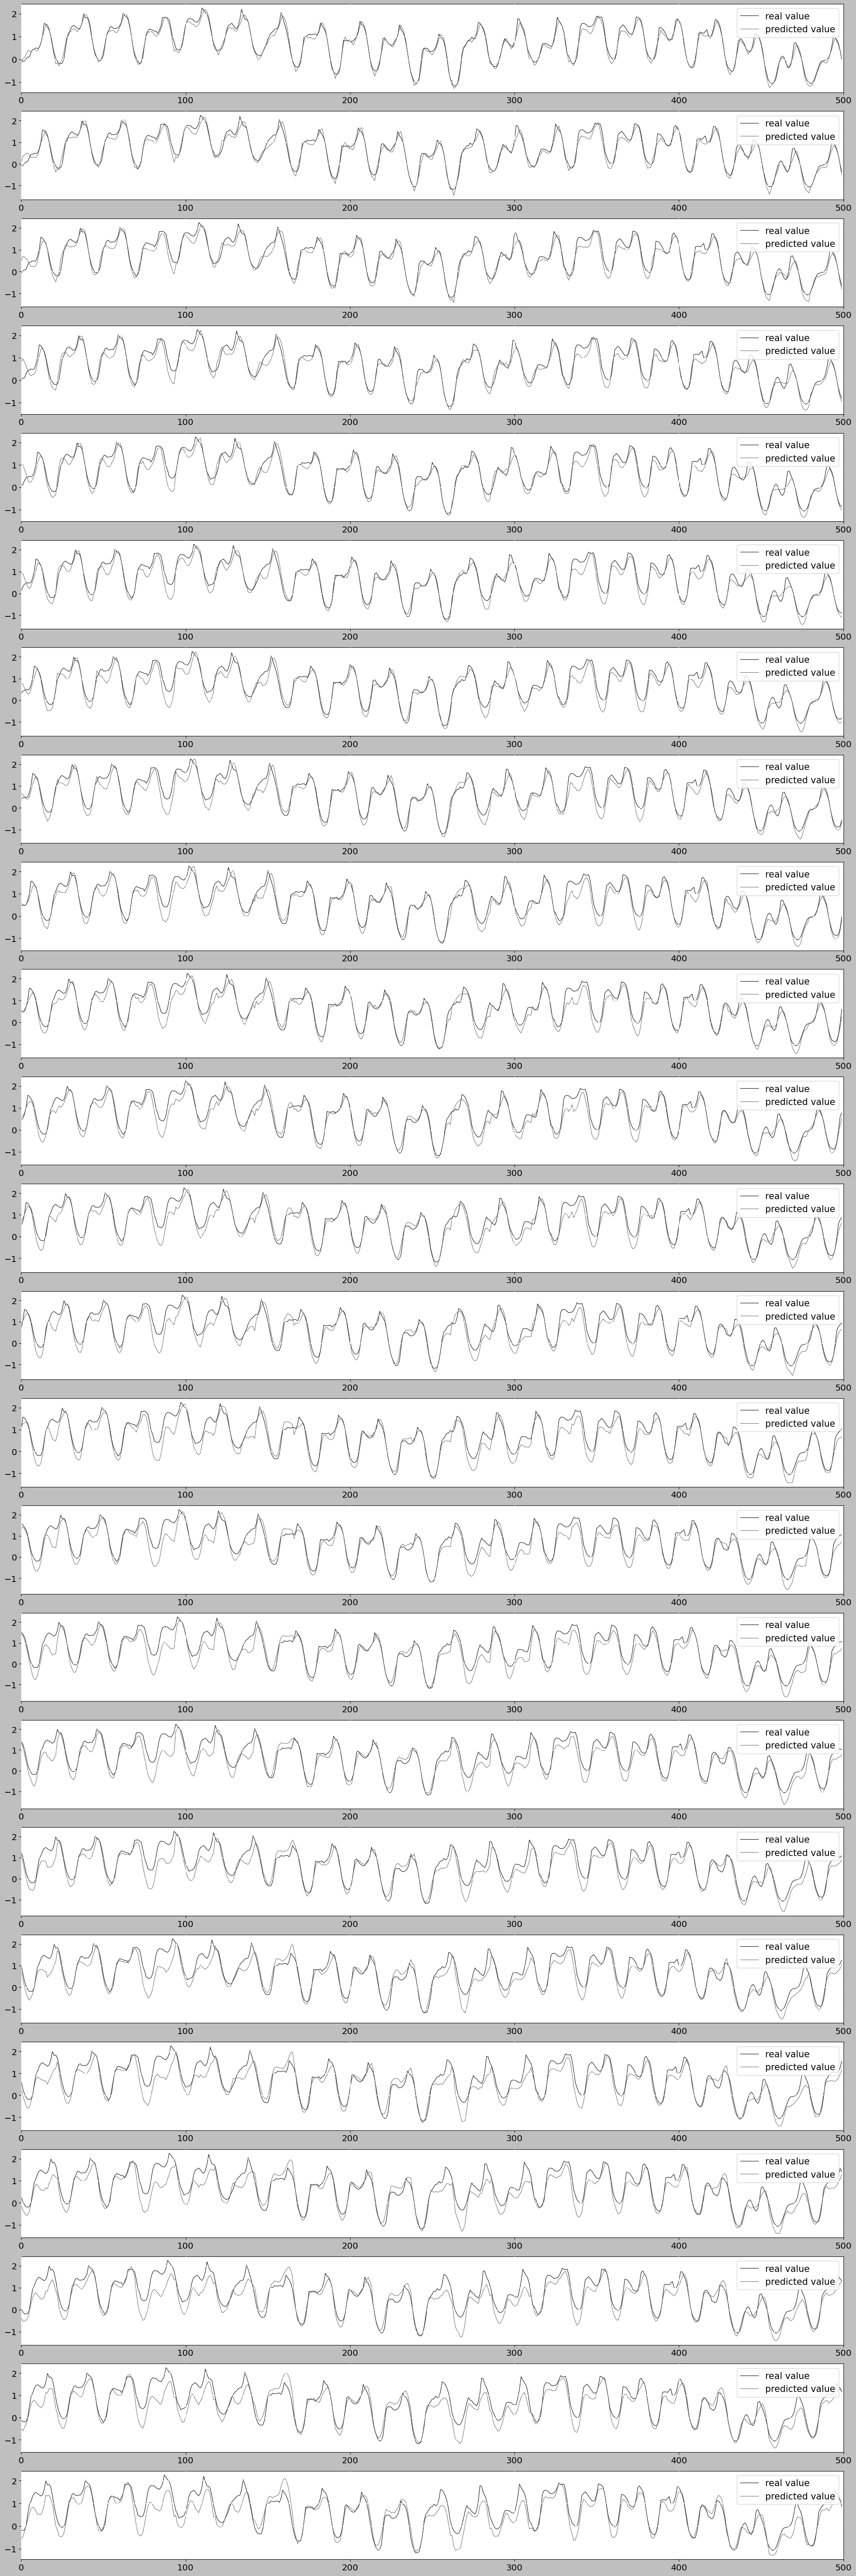

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(24, 1, figsize=(20, 60))  # Create a figure with 12 subplots
y_predict = model.predict(x_test)
y_predict_array = np.array(y_predict)
# y_predict_array = y_predict_array.reshape(len(y_test), 12)
for i in range(24):
    y_test1 = y_test[:, i]
    y_pre = y_predict_array[:, i]
    # print(y_test1.shape, y_pre.shape)
    draw = pd.concat([pd.DataFrame(y_test[:500, i]), pd.DataFrame(y_pre)], axis=1)
    draw.iloc[:, 0].plot(ax=axs[i])  # Plot y_test value in the corresponding subplot
    draw.iloc[:, 1].plot(ax=axs[i])  # Plot predicted value in the corresponding subplot
    axs[i].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    # axs[i].title(f"Test Data vs Predicted after {i+1} hours", fontsize='20')
    axs[i].set_xlim(0, len(y_test1[:]))  # Set the x-axis limits for each subplot

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [ ]:
result=pd.read_csv('/content/Results.csv')
result

,Unnamed: 0,Generation,Parameters,learning_rate,MAPE,generation
0,0,NaN,80-527-0.0001,NaN,1.164075,0.0
1,0,NaN,80-527-0.0001,NaN,1.115757,1.0


In [ ]:
result[['Batch Size', 'Epochs', 'Learning Rate']]=result['Parameters'].str.split('-',expand=True)
evaluate_result=result[['Batch Size','Epochs','Learning Rate','MAPE']]
evaluate_result=evaluate_result.dropna()
evaluate_result

,Batch Size,Epochs,Learning Rate,MAPE
0,80,527,0.0001,1.164075
1,80,527,0.0001,1.115757


In [ ]:
evaluate_result.describe()

,MAPE
count,2.000000
mean,1.139916
std,0.034166
min,1.115757
25%,1.127837
50%,1.139916
75%,1.151996
max,1.164075


In [ ]:
print(evaluate_result.min())
print()
print(evaluate_result.max())

Batch Size             80
Epochs                527
Learning Rate      0.0001
MAPE             1.115757
dtype: object

Batch Size             80
Epochs                527
Learning Rate      0.0001
MAPE             1.164075
dtype: object


In [ ]:
print(evaluate_result[evaluate_result.MAPE == evaluate_result.MAPE.min()])
print()
print(evaluate_result[evaluate_result.MAPE == evaluate_result.MAPE.max()])

  Batch Size Epochs Learning Rate      MAPE
1         80    527        0.0001  1.115757

  Batch Size Epochs Learning Rate      MAPE
0         80    527        0.0001  1.164075


## PREDICTION FOR WHOLE YEAR

In [ ]:
pd.set_option('display.max_columns', 100)
dfpredict_data = df_orig.loc['2010', :].copy(deep=True)
predict_data = dfpredict_data[['temp', 'dew_point_temp', 'rel_hum','wind_speed', 'visibility', 'press','hour_of_day','month','day_of_week', 'day_of_year', 'week_of_year','quarter','daily_peak','hourly_demand']]
predict_data

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hour_of_day,month,day_of_week,day_of_year,week_of_year,quarter,daily_peak,hourly_demand
2010-01-01 00:00:00,0.8,0.1,95.0,7.0,12.9,99.17,0.0,1.0,4.0,1.0,53.0,1.0,17915.0,14403.0
2010-01-01 01:00:00,0.6,0.0,96.0,9.0,9.7,99.13,1.0,1.0,4.0,1.0,53.0,1.0,17915.0,13814.0
2010-01-01 02:00:00,0.7,0.0,95.0,13.0,9.7,99.13,2.0,1.0,4.0,1.0,53.0,1.0,17915.0,13366.0
2010-01-01 03:00:00,0.5,-0.5,93.0,9.0,16.1,99.18,3.0,1.0,4.0,1.0,53.0,1.0,17915.0,13120.0
2010-01-01 04:00:00,0.5,-0.6,92.0,9.0,16.1,99.17,4.0,1.0,4.0,1.0,53.0,1.0,17915.0,13075.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-31 19:00:00,7.0,5.7,91.0,7.0,24.1,99.30,19.0,12.0,4.0,365.0,52.0,4.0,17608.0,16511.0
2010-12-31 20:00:00,6.9,6.2,95.0,7.0,16.1,99.30,20.0,12.0,4.0,365.0,52.0,4.0,17608.0,15758.0
2010-12-31 21:00:00,7.7,7.0,95.0,6.0,16.1,99.30,21.0,12.0,4.0,365.0,52.0,4.0,17608.0,15116.0
2010-12-31 22:00:00,8.1,7.4,95.0,6.0,19.3,99.27,22.0,12.0,4.0,365.0,52.0,4.0,17608.0,14529.0


In [ ]:
scaler=StandardScaler()
predict=scaler.fit_transform(np.array(predict_data))
predict

array([[-0.82381055, -0.3973762 ,  1.41915897, ..., -1.35174944,
        -0.33039956, -0.70281945],
       [-0.84227601, -0.40702618,  1.47816626, ..., -1.35174944,
        -0.33039956, -0.92911582],
       [-0.83304328, -0.40702618,  1.41915897, ..., -1.35174944,
        -0.33039956, -1.10123937],
       ...,
       [-0.18675203,  0.26847195,  1.41915897, ...,  1.33457658,
        -0.46890501, -0.42888175],
       [-0.1498211 ,  0.30707184,  1.41915897, ...,  1.33457658,
        -0.46890501, -0.65440971],
       [-0.14058837,  0.33602176,  1.53717355, ...,  1.33457658,
        -0.46890501, -0.92527377]])

In [ ]:
xp = np.array([np.concatenate((predict[i-2,:], predict[i-1,:], predict[i,:])) for i in range(2, len(predict)-24)])
print(f'xp.shape: {xp.shape}')
yp = np.array([np.stack([predict[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(predict)-24)])
print(f'yp.shape: {yp.shape}')

xp.shape: (8734, 42)
yp.shape: (8734, 24)


In [ ]:
xp.shape
y_prediction = model.predict(xp)
y_prediction_array = np.array(y_prediction)

273/273 [==============================] - 1s 2ms/step


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(yp, y_prediction)
print("Mean Absolute Percentage Error (MAPE):", mape)
print(yp.shape)
print(y_prediction.shape)
mape_values = []
for actual, predicted in zip(yp, y_prediction):
    mape_values.append(mean_absolute_percentage_error([actual], [predicted]))

worst_mape = np.max(mape_values)
best_mape = np.min(mape_values)

print("Worst MAPE:", worst_mape)
print("Best MAPE:", best_mape)


Mean Absolute Percentage Error (MAPE): 1.9748343638490262
(8734, 24)
(8734, 24)
Worst MAPE: 159.5755986057503
Best MAPE: 0.07373153810538528


##VISUALISATION

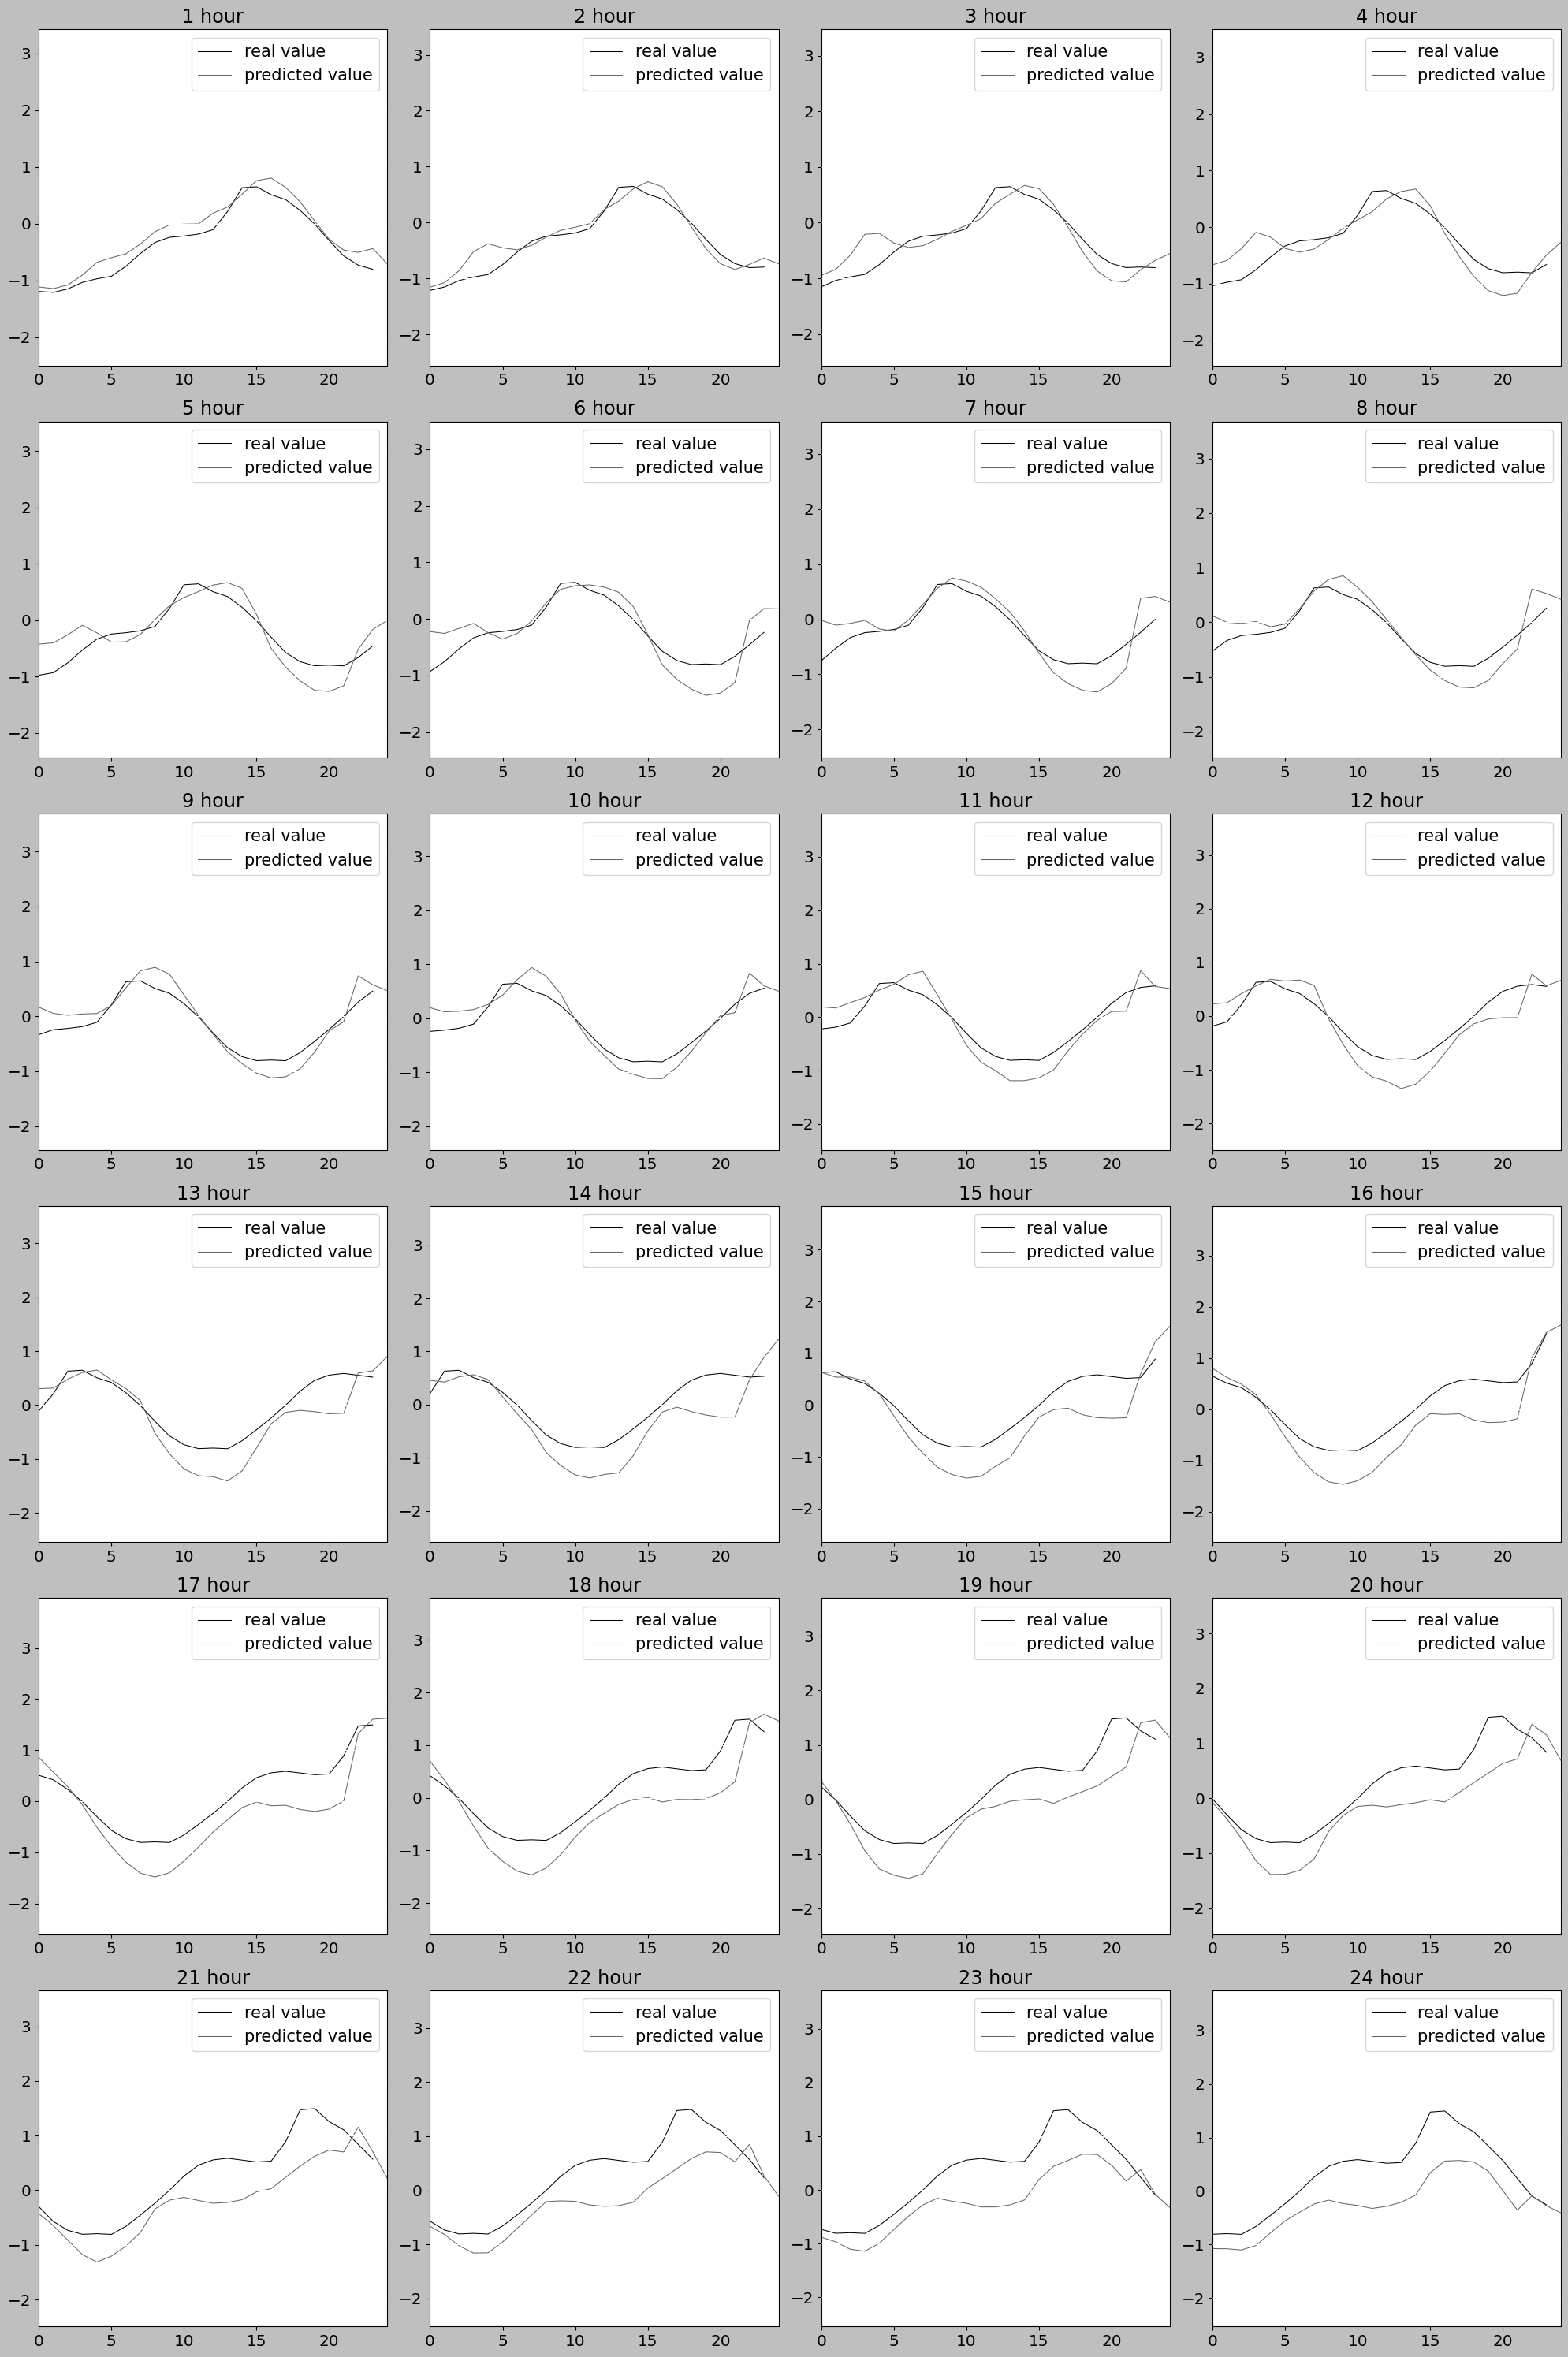

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 30))  # Create a figure with 6 rows and 4 columns of subplots


for i in range(24):
    row = i // 4  # Calculate the row index for the subplot
    col = i % 4  # Calculate the column index for the subplot

    y_prede = y_prediction_array[:, i]
    draw = pd.concat([pd.DataFrame(yp[:24, i]), pd.DataFrame(y_prede)], axis=1)

    axs[row, col].plot(draw.iloc[:, 0])  # Plot y_test value in the corresponding subplot
    axs[row, col].plot(draw.iloc[:, 1])  # Plot predicted value in the corresponding subplot
    axs[row, col].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    axs[row, col].set_xlim(0, len(yp[:24]))  # Set the x-axis limits for each subplot
    axs[row, col].set_title(f"{i+1} hour")  # Add a title to the subplot indicating the hour

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [ ]:
df_predict_aggregate = pd.DataFrame(columns=['prediction_agg', 'actual'])
def aggregate_plot(y_actual, y_pred):
  y_mean_pred = []
  for j in range(23, -1, -1):
    sum=0
    for i in range(0, 24):
      if j-i>=0:
        sum += y_pred[i][j-i]
    y_mean_pred.append(sum/(j+1))
  y_mean_pred = list(reversed(y_mean_pred))
  df_predict_aggregate['prediction_agg'] = y_mean_pred
  df_predict_aggregate['actual'] = y_actual

  mape = mean_absolute_percentage_error(yp, y_prediction)
  print(mape)
  plt.plot(y_actual, marker='*', color='blue')
  plt.plot(y_mean_pred, marker='+', color ='red')
  plt.legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
  plt.show()

In [ ]:
df_predict_aggregate

,prediction_agg,actual
0,-0.253320,-0.443482
1,-0.100964,-0.342820
2,0.245380,-0.107303
3,0.667459,0.480146
4,1.031513,1.166719
5,1.220244,1.353058
6,1.250957,1.326932
7,1.194982,1.376879
8,1.130954,1.402236
9,1.084526,1.373421


1.9748343638490262


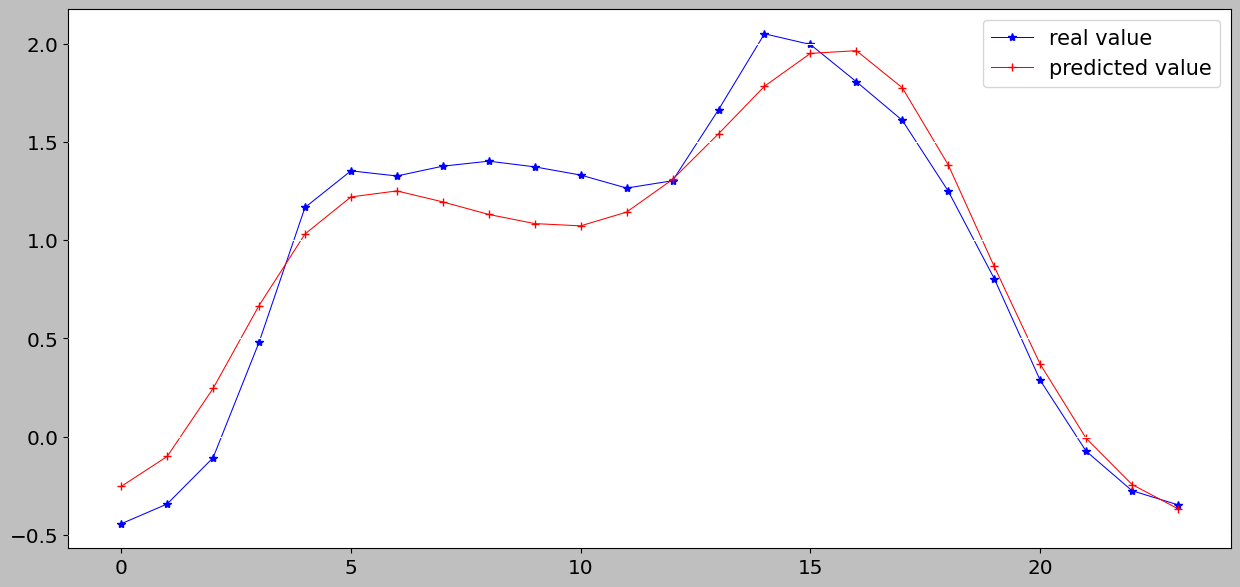

In [ ]:
aggregate_plot(yp[240], y_prediction[240:264])